# Setup on TACC

In terminal:
- Go to home directory: `cd ~/`
- Make python venv: `python3 -m venv venv_39`
- Go to scratch directory: `cds`
- Clone brainlit: `git clone https://github.com/neurodata/brainlit.git`
- Install in editable mode `cd brainlit && pip install -e .`
- Make jupyter kernel for `venv_39` environment ([tutorial](https://queirozf.com/entries/jupyter-kernels-how-to-add-change-remove)) e.g. `pip install jupyter && ipython kernel install --name "venv_39-home" --user`

In Jupyter Notebook:
- Make sure kernel is the one you made for `venv_39` e.g. `venv_39-home`
- Run code below

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from brainlit.BrainLine.util import (
    json_to_points,
    download_subvolumes,
)
from brainlit.BrainLine.apply_ilastik import (
    ApplyIlastik,
    ApplyIlastik_LargeImage,
    plot_results,
    examine_threshold,
)
from brainlit.BrainLine.analyze_results import SomaDistribution
from brainlit.BrainLine.imports import *
import json
from matplotlib_scalebar.scalebar import ScaleBar

### In this notebook we validate, process, and view results from a portion of an image

In [4]:
brainlit_path = Path("/scratch/09423/tathey1/brainlit")
data_file = (
    brainlit_path / "docs" / "notebooks" / "pipelines" / "BrainLine" / "soma_data.json"
)
# Modify base path of test sample according to your system
with open(data_file, "r") as f:
    data = json.load(f)

data["brain2paths"]["test"]["base"] = (
    "precomputed://file://"
    + str(
        brainlit_path
        / "docs"
        / "notebooks"
        / "pipelines"
        / "BrainLine"
        / "example-data"
    )
    + "/"
)

brain2paths = data["brain2paths"]

with open(data_file, "w") as f:
    json.dump(data, f, indent=4)
    
brain = "test"  # brain ID
soma_data_dir = (
    str(
        brainlit_path
        / "docs"
        / "notebooks"
        / "pipelines"
        / "BrainLine"
        / "validation-data"
        / "soma"
    )
    + "/"
)  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val
antibody_layer, background_layer, endogenous_layer = "antibody", "background", "endogenous"
layer_names = [antibody_layer, background_layer, endogenous_layer]

# Download

In [9]:
download_subvolumes(
    soma_data_dir,
    brain_id=brain,
    data_file=data_file,
    layer_names=layer_names,
    dataset_to_save=dataset_to_save,
)

fg shape: (7410, 4424, 3000, 1) at [1830. 1830. 2000.]
bg shape: (7410, 4424, 3000, 1) at [1830. 1830. 2000.]
endo shape: (7410, 4424, 3000, 1) at [1830. 1830. 2000.]
[3, 3] centers
Downloaded data will be stored in /scratch/09423/tathey1/brainlit/docs/notebooks/pipelines/BrainLine/validation-data/soma/braintest/val


Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

Downloading: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

Downloading: 100%|██████████| 4/4 [00:00<00:00, 34.54it/s]

Downloading: 100%|██████████| 4/4 [00:00<00:00, 34.86it/s]

Downloading: 100%|██████████| 4/4 [00:00<00:00, 34.70it/s]

Downloading: 100%|██████████| 4/4 [00:00<00:00, 34.84it/s]

Downloading: 100%|██████████| 4/4 [00:00<00:00, 34.65it/s]

Downloading: 100%|██████████| 4/4 [00:00<00:00, 34.94it/s]

Downloading: 100%|██████████| 2/2 [00:00<00:00, 17.35it/s]

Downloading: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s]

Downloading: 100%|██████████| 2/2 [00:00<00:00, 17.29it/s]

Downloading: 100%|██████████| 2/2 [00:00<00:00, 17.43it/s]

Saving samples: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


# View [also possible in napari]

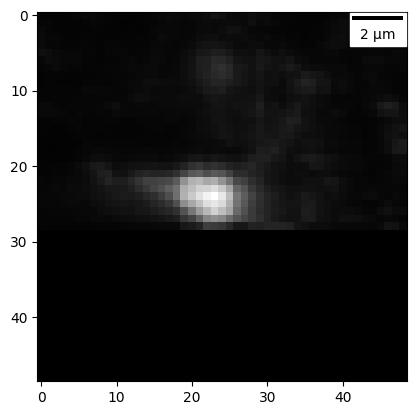

In [5]:
fname = Path(soma_data_dir) / f"brain{brain}" / "val" / "2008_1995_1842_pos.h5"
scale = [1.8, 1.8, 2]  # voxel size in microns

with h5py.File(fname, "r") as f:
    im = f.get("image_3channel")
    image_fg = im[0, :, :, :]
    image_bg = im[1, :, :, :]
    image_endo = im[2, :, :, :]
    


plt.imshow(np.amax(image_fg, axis=0), cmap='gray')


scalebar = ScaleBar(0.3, "um")
plt.gca().add_artist(scalebar)
plt.show()

# Predict on Validation Data

In [11]:
ilastik_project = str(
    brainlit_path
    / Path("experiments/BrainLine/data/models/soma/matt_soma_rabies_pix_3ch.ilp")
)  # path to ilastik model to be used
ilastik_path = "/scratch/09423/tathey1/ilastik-1.4.0-Linux/run_ilastik.sh"  # path to ilastik executable (see here: https://www.ilastik.org/documentation/basics/headless.html)
brains = [brain]

In [13]:
applyilastik = ApplyIlastik(
    ilastik_path=ilastik_path,
    project_path=ilastik_project,
    brains_path=soma_data_dir,
    brains=brains,
)
applyilastik.process_subvols(ncpu=6)

running ilastik...: 100%|██████████| 6/6 [00:00<00:00, 54.85it/s]


Processing Brains: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


If this performance is not adequate, improve model and try again


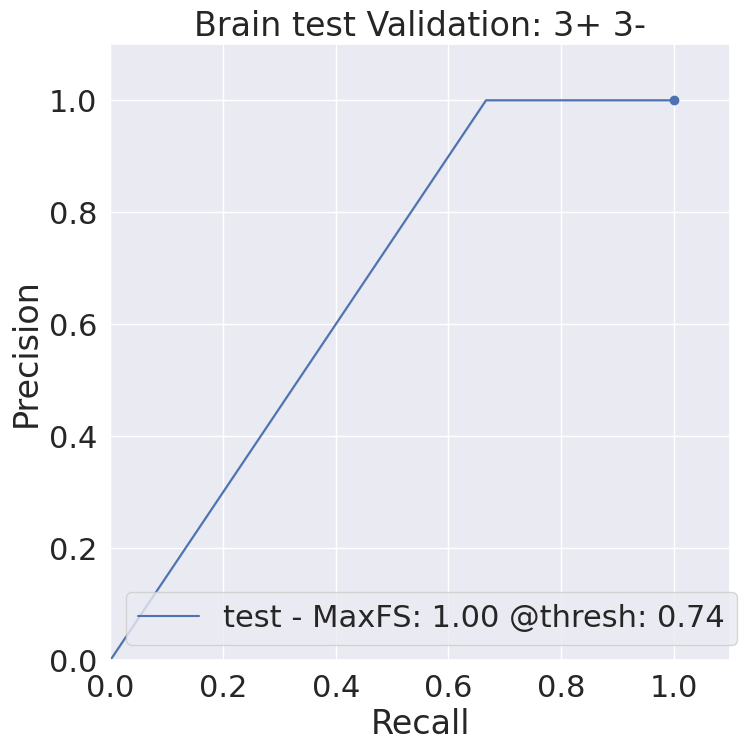

In [14]:
fig, _, _ = plot_results(
    data_dir=soma_data_dir,
    brain_ids=[brain],
    object_type="soma",
    positive_channel=0,
    doubles=[],
)
plt.show()

# Predict Full Image

In [15]:
threshold = 0.76  # threshold to use for ilastik
data_dir = (
    soma_data_dir + "brainr_temp/"
)  # "/data/tathey1/matt_wright/brainr_temp/"  # directory to store temporary subvolumes for segmentation
results_dir = (
    soma_data_dir + "brainr_results/"
)  # directory to store coordinates of soma detections

min_coords = [2000, 1900, 1800]
max_coords = [2100, 2000, 1900]  # -1 if you want to process the whole dimension

ncpu = 1  # 16  # number of cores to use for detection
chunk_size = [100, 100, 100]  # [256, 256, 300]

layer_names = [antibody_layer, background_layer, endogenous_layer]

ilastik_largeimage = ApplyIlastik_LargeImage(
    ilastik_path=ilastik_path,
    ilastik_project=ilastik_project,
    data_file=data_file,
    results_dir=results_dir,
    ncpu=1,
)

In [16]:
ilastik_largeimage.apply_ilastik_parallel(
    brain_id=brain,
    layer_names=layer_names,
    threshold=threshold,
    data_dir=data_dir,
    chunk_size=chunk_size,
    min_coords=min_coords,
    max_coords=max_coords,
)

Processing: precomputed://file:///scratch/09423/tathey1/brainlit/docs/notebooks/pipelines/BrainLine/example-data/antibody with shape (7410, 4424, 3000, 1) at threshold 0.76
Downloaded data will be stored in /scratch/09423/tathey1/brainlit/docs/notebooks/pipelines/BrainLine/validation-data/soma/brainr_temp/
Downloaded data will be stored in /scratch/09423/tathey1/brainlit/docs/notebooks/pipelines/BrainLine/validation-data/soma/brainr_results


  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                                      
  0%|          | 0/45 [00:00<?, ?it/s]
                         

# [Register and transform detected points]

# View Results [also possible in napari and brainrender]

In [17]:
colors = {
    "test_type": "red",
}  # colors for different sample types
symbols = ["o", "+", "^", "vbar"]
brain_ids = ["test"]
fold_on = False

ontology_file = (
    brainlit_path / "brainlit" / "Brainline" / "data" / "ara_structure_ontology.json"
)
sd = SomaDistribution(
    brain_ids=brain_ids, data_file=data_file, ontology_file=ontology_file
)

Brain test: Collecting atlas space soma points from layer: transformed_points


Finding soma regions of brains: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Processing brains in z=1073: 100%|██████████| 1/1 [00:00<00:00, 63.23it/s]


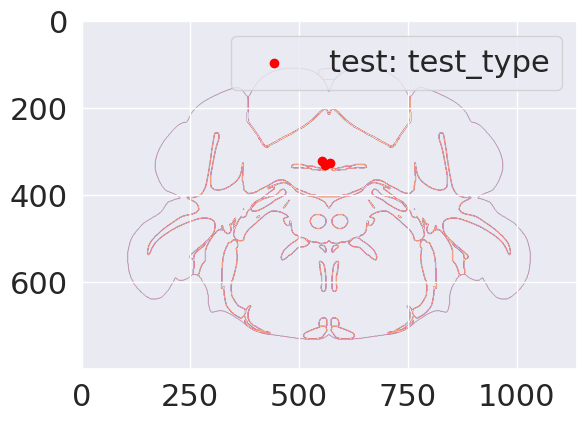

In [18]:
f = sd.napari_coronal_section(
    z=1073, subtype_colors=colors, symbols=symbols, fold_on=fold_on, plot_type="plt"
)
plt.show()

Populating: Cerebellum
Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Striatum
Populating: Bed nuclei of the stria terminalis
Populating: Hypothalamus
Populating: Thalamus
Populating: Lateral habenula
Populating: Cerebellar nuclei
Populating: Midbrain
Populating: Hindbrain
Populating: Amygdalar Nuclei


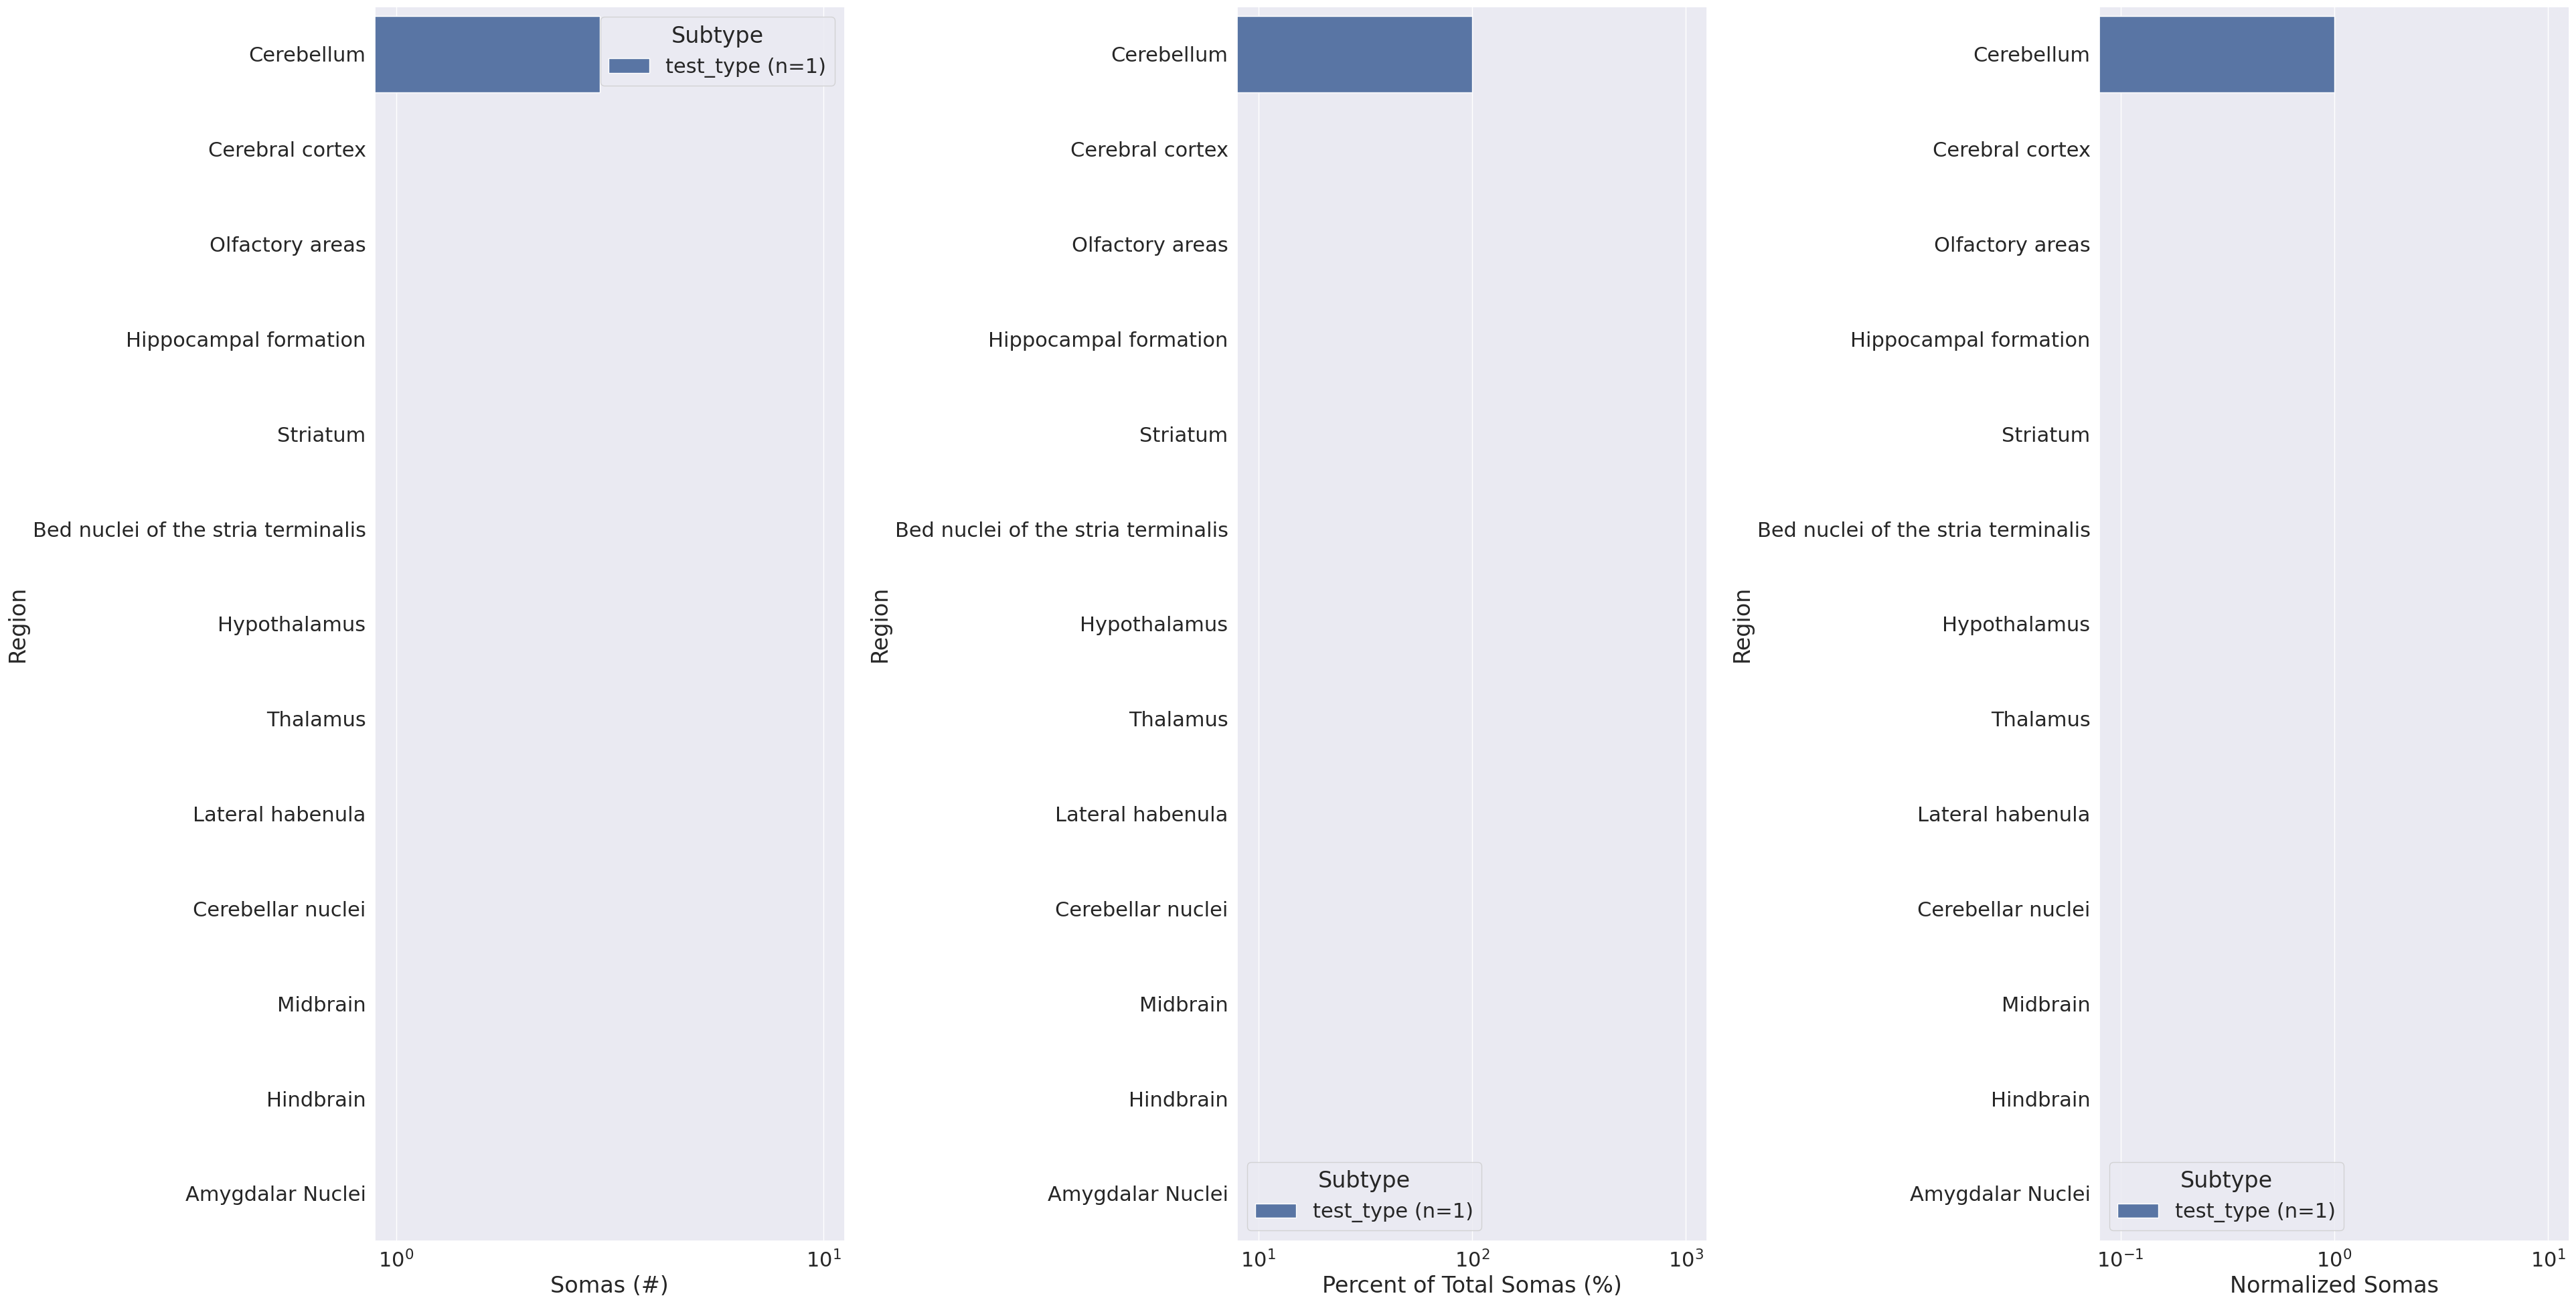

In [19]:
regions = [
    512,  # cerebellum
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions

sd.region_barchart(regions, composite_regions=composite_regions, normalize_region=512)

# Other visualization modes (when GUI environments are available e.g. locally)

## Napari

![napari](https://github.com/neurodata/brainlit/blob/develop/docs/notebooks/pipelines/BrainLine/images/napari-soma.png?raw=true)

## Brainrender

![brainrender](https://github.com/neurodata/brainlit/blob/develop/docs/notebooks/pipelines/BrainLine/images/brainrender-soma.png?raw=true)